In [1]:
%cd /home/kawamanmi/Projects/PyBaMM/src
import pybamm
import numpy as np

c_rate_formation = 20  # Assuming this is defined elsewhere
c_rate_cycling = 1/20


formation_cycle = [
    (f"Charge at C/{c_rate_formation} until 4.2 V"),
    (f"Discharge at C/{c_rate_formation} until 2.5 V"),
]

cycling = [
    f"Charge at {c_rate_cycling}C until 4.2 V",
    f"Discharge at {c_rate_cycling}C until 2.5 V",
]

exp = pybamm.Experiment(
    formation_cycle * 2 +
    cycling * 3
)

#
sei_options = [ "ec reaction limited", "ec reaction limited", "ec reaction limited",  "electron-migration limited",  "interstitial-diffusion limited", "tunnelling limited" , "Kolzenberg2020" ]
label_sei_options = ["RL", "DL", "Mixed", "EM", "ID", "ET", "VK"]  


common_params = {
    'Initial inner SEI thickness [m]': 5e-13,
    'Initial outer SEI thickness [m]': 5e-13,
    "EC initial concentration in electrolyte [mol.m-3]": 4541.0,
    'Inner SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
    'tunneling distance for electrons [m]': 0,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    "SEI open-circuit potential [V]": 0.0,
}
k_sei =[ 7.0e-13, 1e-7, 1e-10, 1, 1, 7.0e-13, 1]
D_sol = [1e-14,1e-22, 0.8e-22, 1, 1, 1e-14, 1 ]
inner_outer_proposionality= [0, 0, 0, 1, 0, 1, 1]
params = []
for i in range(0, len(k_sei)):
  param=pybamm.ParameterValues('Chen2020')
  param.update({**common_params, 
    'SEI kinetic rate constant [m.s-1]':k_sei[i],
    'Outer SEI solvent diffusivity [m2.s-1]':D_sol[i],      
    "EC diffusivity [m2.s-1]": D_sol[i],
    'Inner SEI reaction proportion': inner_outer_proposionality[i],
    } ,check_already_exists=False
              )
  params.append(param)
  
  
models = [pybamm.lithium_ion.SPM({
                                  "SEI": sei_option}) for sei_option in sei_options]


solver = pybamm.CasadiSolver(mode="safe", extra_options_setup={"max_num_steps": 100000})

sims = [pybamm.Simulation(model, parameter_values=params[index],
                          experiment=exp, solver=solver) for index, model in enumerate(models)]
sols = [sim.solve(initial_soc=0) for sim in sims]


/home/kawamanmi/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/kawamanmi/Projects/PyBaMM/src


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%cd /home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
df_formation = pd.read_csv("experimental/FC_05_formation_0.csv")
df_cycles= pd.read_csv("experimental/FC_05_cycling_1.csv")

mode_diff = df_formation["mode"].diff()
index_switch = mode_diff[mode_diff != 0].index.to_list()
index_switch_formation = [0] + [i -1 for i in index_switch[1:]] + [len(df_formation["mode"])-1]


mode_diff = df_cycles["mode"].diff()
index_switch = mode_diff[mode_diff != 0].index.to_list()
index_switch_cycles = [0] + [i -1 for i in index_switch[1:]] + [len(df_cycles["mode"])-1]

# Specify which cycle you want to include up to (e.g., up to the 3rd cycle)
cycle_limit = 15  # Change this to include more or fewer cycles

# Get the index for the end of the specified cycle
end_index = index_switch_cycles[cycle_limit] if cycle_limit < len(index_switch_cycles) else index_switch_cycles[-1]

# Slice df_cycles up to the specified cycle
df_cycles_limited = df_cycles.iloc[:end_index + 1]

# Combine df_formation and the limited df_cycles
df_combined = pd.concat([df_formation, df_cycles_limited])

# plt.plot(df_cycles["time/s"]/3600, df_cycles["Ecell/V"])


A_cell = np.pi * 1.48 ** 2 / 4
# capacity first charge
capacity_1ch = (df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[2]] - df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[0]]) / A_cell

# capacity first discharge
capacity_1dch = (df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[3]] - df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[4]]) / A_cell

# capacity second charge
capacity_2ch = (df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[7]] - df_formation
                
                ["(Q-Qo)/mA.h"].iloc[index_switch_formation[5]]) / A_cell
# capacity second discharge
capacity_2dch = (df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[8]] - df_formation["(Q-Qo)/mA.h"].iloc[index_switch_formation[9]]) / A_cell

# capacity third charge
capacity_3ch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[2]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[0]]) / A_cell

# capacity third discharge
capacity_3dch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[3]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[4]]) / A_cell

# capacity fourth charge
capacity_4ch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[7]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[5]]) / A_cell

# capacity fourth discharge
capacity_4dch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[8]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[9]]) / A_cell

# capacity fifth charge
capacity_5ch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[12]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[10]]) / A_cell

# capacity fifth discharge
capacity_5dch = (df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[13]] - df_cycles["(Q-Qo)/mA.h"].iloc[index_switch_cycles[14]]) / A_cell



coulombic_efficiency_exp = np.array([capacity_1dch / capacity_1ch, capacity_2dch / capacity_2ch, capacity_3dch / capacity_3ch, capacity_4dch / capacity_4ch, capacity_5dch / capacity_5ch])
capacity_loss_exp = np.array([capacity_1ch - capacity_1dch , capacity_1dch- capacity_2dch , capacity_2dch - capacity_3dch, capacity_4dch - capacity_3dch , capacity_5dch - capacity_4dch ])

# print((1- coulombic_efficiency_exp)*100)
print(coulombic_efficiency_exp)
print(capacity_loss_exp)

/home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
[0.81971496 0.97069808 0.94769231 0.99451613 0.99742185]
[0.44119285 0.04185229 0.17380324 0.00174385 0.00697538]


In [4]:
# %cd -
%cd /home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
import numpy as np

# First subplot
start_cycle = 1  # or whatever cycle number you want to start from
dch_cacpacity= []
ch_cacpacity= []

all_capacity_losses=[]
all_coulombic_efficiencies = []
for index, model in enumerate(models):
    capacity_loss_models =[]
    coulombic_efficiency_models = []
    for cycle_index in range(start_cycle - 1, len(sols[index].cycles)-1, 2):
        time_ch = sols[index].cycles[cycle_index]["Time [s]"].entries 
        time_dch = sols[index].cycles[cycle_index + 1]["Time [s]"].entries
        
        ch_cacpacity = abs(sols[index].cycles[cycle_index]['Discharge capacity [A.h]'](time_ch[-1])) 
                            #   - abs(sols[index].cycles[cycle_index]['Discharge capacity [A.h]'](time_ch[0])) 
        dch_cacpacity = abs(sols[index].cycles[cycle_index + 1]['Discharge capacity [A.h]'](time_dch[-1]) ) 
                    #    - abs(sols[index].cycles[cycle_index + 1]['Discharge capacity [A.h]'](time_dch[0]) )
        # plt.plot(time_dch, 5- sols[index].cycles[cycle_index + 1]['Discharge capacity [A.h]'](time_dch), label = label_sei_options[index])
        # ch_cacpacity_loss = sols[index].cycles[cycle_index]['Total capacity lost to side reactions [A.h]'](time_ch[-1]) 
        # dch_cacpacity_loss = sols[index].cycles[cycle_index + 1]['Total capacity lost to side reactions [A.h]'](time_dch[-1]) -\
        #               sols[index].cycles[cycle_index ]['Total capacity lost to side reactions [A.h]'](time_ch[0]) 
        # # print(dch_cacpacity_loss)
        coulombic_efficiency_models.append(dch_cacpacity / ch_cacpacity)
        if (cycle_index==1):
            capacity_loss_models.append(ch_cacpacity - dch_cacpacity)
            dd = dch_cacpacity
        else:
            dch_cacpacity = abs(sols[index].cycles[cycle_index + 1]['Discharge capacity [A.h]'](time_dch[-1]) )             
            capacity_loss_models.append( dd - dch_cacpacity)
            dd = dch_cacpacity

    all_capacity_losses.append(capacity_loss_models)
    all_coulombic_efficiencies.append(coulombic_efficiency_models)

all_capacity_losses.append(capacity_loss_exp)
all_coulombic_efficiencies.append(coulombic_efficiency_exp)
print((all_coulombic_efficiencies))
print(capacity_loss_models)

/home/kawamanmi/Projects/formation/zero-dimension-comparison-SEI/tests/user_tests
[[0.0024629903416324944, 0.003140931300765144, 0.0038180095028529652, 0.004494194363018996, 0.005169487171847985], [0.002684881847410892, 0.0030613003650244554, 0.0033499158320419013, 0.0035931536110170173, 0.0038074238629202885], [0.0025498016162943432, 0.002877936630559426, 0.003129544724998897, 0.0033416619934496595, 0.003528584258710797], [0.0018041272856207644, 0.0018124320532683436, 0.0018188054606225158, 0.0018241784726958786, 0.0018289127717046197], [0.002237551396191111, 0.0024253443392477435, 0.002569420932123495, 0.002690856681361311, 0.0027978248440776966], [0.002255448743506717, 0.0025384744514077213, 0.0027414002678907397, 0.0028997035670380138, 0.003029513454811896], [0.0021040724523349232, 0.0022806417944427407, 0.0024195471963730265, 0.002537959900065927, 0.00264296595026192], array([0.81971496, 0.97069808, 0.94769231, 0.99451613, 0.99742185])]
[0.004713702628348972, -0.000899351259794312

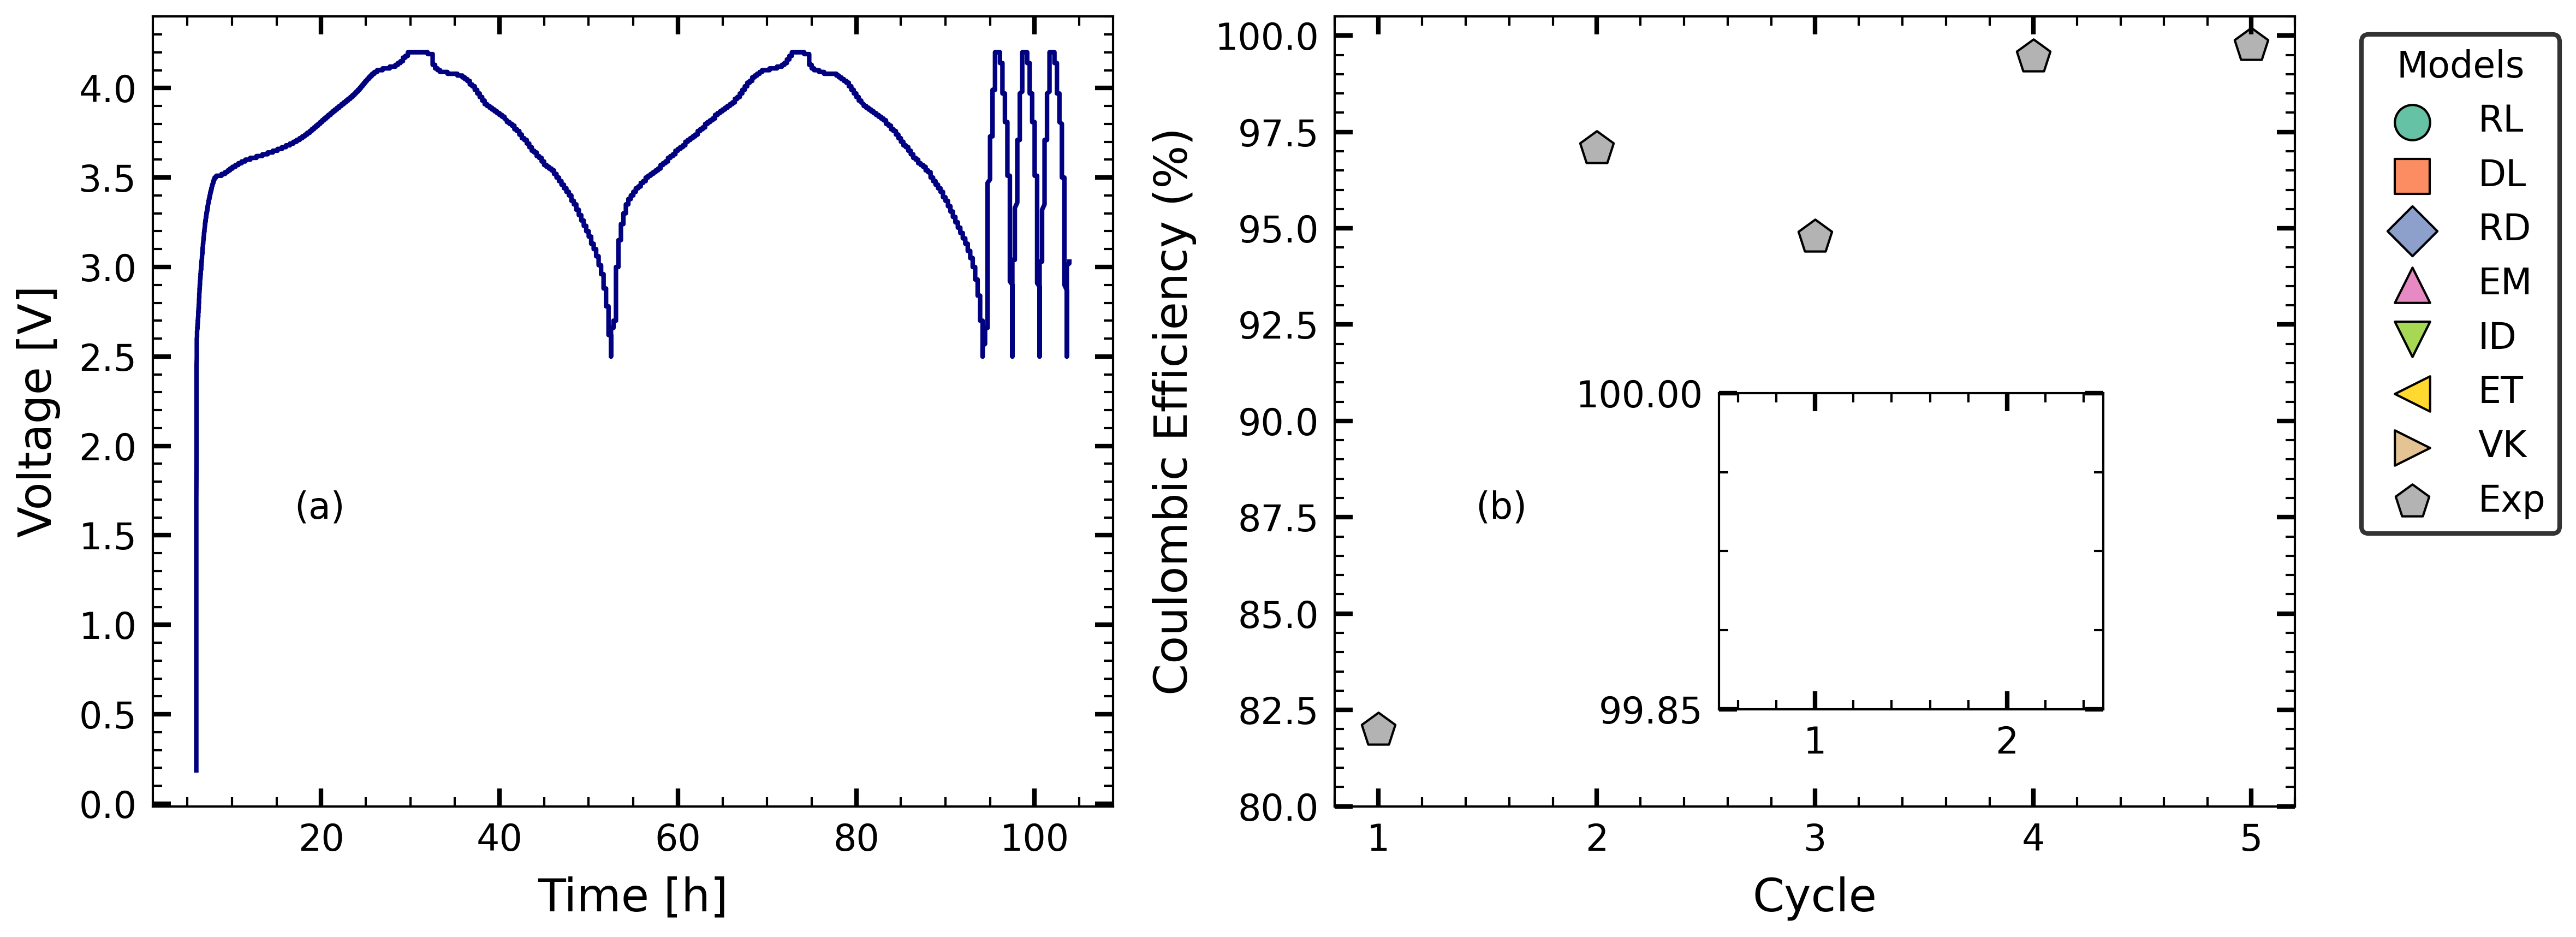

In [5]:
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.ticker as ticker
import numpy as np
from style_figs import set_plotting_format
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use(['science', 'ieee'])
set_plotting_format("paper")  # input should be either "presentation" or "paper"

models = ["RL", "DL", "RD", "EM", "ID", "ET", "VK", "Exp"]
cycles = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Use a colorblind-friendly color palette
colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

# Plot Coulombic efficiency per cycle for all models
for i, (model, color, marker) in enumerate(zip(models, colors, markers)):
    values = [ce * 100 for ce in all_coulombic_efficiencies[i]]
    axes[1].scatter(cycles, values, label=model, color=color, marker=marker, s=60, edgecolors='black', linewidth=0.5)

axes[1].set_ylabel('Coulombic Efficiency (%)')
axes[1].set_xlabel('Cycle')
axes[1].set_xticks(cycles)
axes[1].legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, edgecolor='black')

# Set y-axis limits to focus on the upper part
y_min = min([min(model_data) * 100 for model_data in all_coulombic_efficiencies])
y_min = max(y_min - 1, 80)  # Set lower limit to 80% or slightly below the minimum value
axes[1].set_ylim(y_min, 100.5)

# Create an inset axes for the zoomed view
axins = inset_axes(axes[1], width="40%", height="40%", loc='lower center', 
                   bbox_to_anchor=(0.1, 0.1, 1, 1), bbox_transform=axes[1].transAxes)

# Plot the zoomed view for the first two cycles (excluding experimental data)
for i, (model, color, marker) in enumerate(zip(models[:-1], colors[:-1], markers[:-1])):
    values = [ce * 100 for ce in all_coulombic_efficiencies[i][:2]]
    axins.scatter([1, 2], values, color=color, marker=marker, s=40, edgecolors='black', linewidth=0.5)

axins.set_xlim(0.5, 2.5)
axins.set_ylim(99.85, 100.0)  # Adjust these limits as needed
axins.set_xticks([1, 2])
axins.set_yticks([99.85, 100.0])
axins.set_xticklabels([1, 2])
# axins.set_xticklabels([1, 2])
# axins.set_title('Cycles 1-2', fontsize=8)

# Plot for the first subplot
axes[0].plot(df_combined["time/s"]/3600, df_combined["Ecell/V"], color='navy')
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Voltage [V]")

axes[0].text(0.2, 0.4, '(a)', transform=axes[0].transAxes, va='top', ha='right')
axes[1].text(0.2, 0.4, '(b)', transform=axes[1].transAxes, va='top', ha='right')

plt.tight_layout()
plt.savefig("figs/exp_models_voltage_CE5.png", dpi=300, bbox_inches='tight')
plt.show()